In [119]:
from langchain_groq import ChatGroq
from dotenv import load_dotenv
import os
load_dotenv()
import json_repair

model = ChatGroq(api_key=os.getenv('GROQ_API_KEY'),
        model="llama-3.3-70b-versatile",
        temperature=1)


In [2]:
def mulitply(a: int, b: int) -> int:
    """
    function that help Multiply a and b

    Args:
        a: first int
        b: second int
    """

    return a * b 

def add(a: int, b: int) -> int:
    """
    funciton that help in add a to b

    Args:
        a: first int
        b: second int
    """

    return a + b 


def division(a: int, b: int) -> int:
    """
    function that help divide a by b

    Args:
        a: first int
        b: second int
    """

    return a / b 

In [3]:
tools = [mulitply, add, division]
model_with_tools = model.bind_tools(tools)

In [4]:
from langgraph.graph import MessagesState

class State(MessagesState):
    pass


def tool_calling_llm(state: MessagesState):
    return {"messages": [model_with_tools.invoke(state['messages'])]}

In [5]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import tools_condition, ToolNode

graph = StateGraph(State)
graph.add_node("llm_calling", tool_calling_llm)
graph.add_node("tools", ToolNode(tools))

graph.add_edge(START, "llm_calling")
graph.add_conditional_edges(
    "llm_calling",
    tools_condition
)

graph.add_edge("tools", "llm_calling")
combiled_graph = graph.compile()

In [7]:


class Agent:
    def __init__(self, system_message="", model_name="llama-3.3-70b-versatile"):
        self.system_message = system_message
        self.messages = []
        if self.system_message:
            self.messages.append({"role": "system", "content": self.system_message})

        self.model = ChatGroq(
            api_key=os.getenv('GROQ_API_KEY'),
            model=model_name,
            temperature=1
        )
    
    def __call__(self, message):
        """
        Function that take message add it in histroy & pass it to model then save the result in memory also
        """
        self.messages.append({"role": "user", "content": message})
        result = self.execute()
        self.messages.append({"role": "assistant", "content": result})

        return result
    
    def execute(self):
        result = self.model.invoke(self.messages)
        return result.content

In [8]:
agent = Agent(system_message="""

You run in a loop of Thought, Action, PAUSE, Observation.
At the end of the loop you output an Answer
Use Thought to describe your thoughts about the question you have been a
Use Action to run one of the actions available to you - then return PAUSE
Observation will be the result of running those actions.

Your available actions are:

calculate:
e.g. calculate: 4 * 7 / 3
Runs a calculation and returns the number – uses Python so be sure to us

average_dog_weight:
e.g. average_dog_weight: Collie
returns average weight of a dog when given the breed

Example session:

Question: How much does a Bulldog weigh?
Thought: I should look the dogs weight using average_dog_weight
Action: average_dog_weight: Bulldog
PAUSE

You will be called again with this:

Observation: A Bulldog weights 51 lbs

You then output:

Answer: A bulldog weights 51 lbs
""".strip())


In [9]:
def calculate(what):
    return eval(what) + 100

def average_dog_weight(name):
    if name in "Scottish Terrier":
        return("Scottish Terriers average 20 lbs")
    elif name in "Border Collie":
        return("a Border Collies average weight is 37 lbs")
    elif name in "Toy Poodle":
        return("a toy poodles average weight is 7 lbs")
    else:
        return("An average dog weights 50 lbs")

known_actions = {
    "calculate": calculate,
    "average_dog_weight": average_dog_weight
}

In [10]:
print(agent('I have 2 dogs, a border collie and a scottish terrier. what is the their combined weight'))


Thought: To find the combined weight of the two dogs, I need to find the average weight of a Border Collie and a Scottish Terrier. I can use the average_dog_weight action to find the weight of each breed and then add them together.

Action: average_dog_weight: Border Collie
PAUSE


In [305]:
next_prompt = f"Observation: {average_dog_weight('Scottish Terrier')}"

agent(next_prompt)

'Thought: Now that I have the correct weights for both breeds, I can calculate the combined weight of the two dogs by adding their individual weights.\n\nAction: calculate: 37 + 20\nPAUSE'

In [298]:
agent.messages

[{'role': 'system',
  'content': 'You run in a loop of Thought, Action, PAUSE, Observation.\nAt the end of the loop you output an Answer\nUse Thought to describe your thoughts about the question you have been a\nUse Action to run one of the actions available to you - then return PAUSE\nObservation will be the result of running those actions.\n\nYour available actions are:\n\ncalculate:\ne.g. calculate: 4 * 7 / 3\nRuns a calculation and returns the number – uses Python so be sure to us\n\naverage_dog_weight:\ne.g. average_dog_weight: Collie\nreturns average weight of a dog when given the breed\n\nExample session:\n\nQuestion: How much does a Bulldog weigh?\nThought: I should look the dogs weight using average_dog_weight\nAction: average_dog_weight: Bulldog\nPAUSE\n\nYou will be called again with this:\n\nObservation: A Bulldog weights 51 lbs\n\nYou then output:\n\nAnswer: A bulldog weights 51 lbs'},
 {'role': 'user', 'content': 'how much does a toy poodle weight?'},
 {'role': 'assistant

In [12]:
from pydantic import BaseModel

class State(BaseModel):
    graph_state: str



State(graph_state="Hello")

State(graph_state='Hello')

In [31]:
def node_1(state):
    print("---Node 1---")
    return {"graph_state": state.graph_state +" I am"}

def node_2(state):
    print("---Node 2---")
    return {"graph_state": state.graph_state +" happy!"}

def node_3(state):
    print("---Node 3---")
    return {"graph_state": state.graph_state +" sad!"} 

In [32]:
import random

def decide_mood(state: State):
    user_input = state.graph_state

    if random.random() < 0.5:
        return "node_2"
    
    return "node_3"

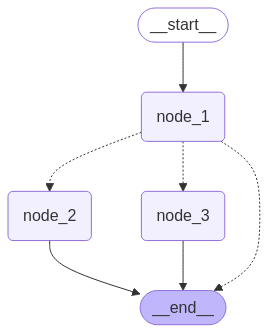

In [37]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END


graph = StateGraph(State)
graph.add_node("node_1", node_1)
graph.add_node("node_2", node_2)
graph.add_node("node_3", node_3)

graph.add_edge(START, "node_1")
graph.add_conditional_edges(
    "node_1",
    decide_mood
)
graph.add_edge("node_2", END)
graph.add_edge('node_3', END)

graph = graph.compile()
graph

In [36]:
graph.invoke({"graph_state": "HI"})

---Node 1---
---Node 2---


{'graph_state': 'HI I am happy!'}

In [88]:
class EmailContent(BaseModel):
    subject: str
    sender: str
    body: str

class MessageContent(BaseModel):
    role: str
    content: str


In [133]:
from typing import Optional, List

class EmailContent(BaseModel):
    subject: str
    sender: str
    body: str

class MessageContent(BaseModel):
    role: str
    content: str


class EmailState(BaseModel):
    email: EmailContent
    email_category: Optional[str] = None
    spam_reason: Optional[str] = None

    is_spam: bool
    email_draft: str
    messages: List[MessageContent] = []

In [134]:
email_content = EmailContent(
    subject="AI engineer for open position",
    sender="Mohamed Hassan",
    body="Hello, I am mohamed and need to apply for that open job position"
)

EmailState(
    email=email_content,
    email_category="CV",
    spam_reason="No spam",
    is_spam=False,
    email_draft="Hello"
)

EmailState(email=EmailContent(subject='AI engineer for open position', sender='Mohamed Hassan', body='Hello, I am mohamed and need to apply for that open job position'), email_category='CV', spam_reason='No spam', is_spam=False, email_draft='Hello', messages=[])

In [135]:
def read_email(state: EmailState):
    email = state.email

    print(f"Foodics' HR is processing an email from {email.sender} with subject: {email.subject}")

    return {}

read_email(EmailState(
    email=email_content,
    email_category="CV",
    spam_reason="No spam",
    is_spam=False,
    email_draft="Hello"
))

Foodics' HR is processing an email from Mohamed Hassan with subject: AI engineer for open position


{}

In [178]:
def classify_email(state: EmailState):
    email = state.email

    prompt = f"""
As foodics' HR, you will get emails .. analyze this email and determine if it is spam or legitimate.


Email:
From: {email.sender}
Subject: {email.subject}
Body: {email.body}


First, determine if this email is spam. If it is spam, explain why.
If it is legitimate, categorize it (inquiry, complaint, thank you).
response in this format only:

{{
    "Analysis": ...,
    "class": ...
}}
"""
    

    response = model.invoke(prompt).content.lower()

    response_json = json_repair.loads(response)
    category = response_json['class']

    print(f"Email category: {category}")
    
    if category == "spam":
        is_spam = True
        spam_reason = response_json['analysis']
    else:
        is_spam = False
        spam_reason = "Not Spam"

    new_messages = state.messages + [
        {"role": "user", "content": prompt},
        {"role": "assistant", "content": response}
    ]

    
    state.is_spam = is_spam,
    state.spam_reason = spam_reason,
    state.email_category = category,
    state.messages = new_messages

In [179]:
email_content = EmailContent(
    subject="RE: AI job position",
    sender="Mohamed Hassan",
    body="just need money"
)

email = EmailState(
    email=email_content,
    email_category="CV",
    spam_reason="No spam",
    is_spam=False,
    email_draft="Hello"
)

In [180]:
import json
response = classify_email(email)
print(response)

Email category: spam
None


In [193]:
def handle_spam(state: EmailState):
    print(f"Our Foodics' HR marked the email as spam. Reason:\n{state.spam_reason}")
    print("The email has been moved to the spam folder.")

    return {}

def draft_response(state: EmailState):
    email = state.email
    category = state.email_category


    prompt = f"""
As foodics' hr, draft a polite preliminary response to this email.

Email:
FROM: {email.sender}
Subject: {email.subject}
Body: {email.body}

This email has been categorized as: {category}

Draft a brief, professional response that 'Mr. Shikabala' can review and personalize before sending.
"""
    

    respone = model.invoke(prompt).content

    new_messages = state.messages + [
        {"role": "user", "content": prompt},
        {"role": "assistant", "content": respone}
    ]

    state.email_draft = respone
    state.messages = new_messages



def notify(state: EmailState):
    print("IN notify")
    email = state.email

    print("\n" + "="*50)
    print(f"Sir, you've received an email from {email.sender}.")
    print(f"Subject: {email.subject}")
    print(f"Category: {state.email_category}")
    print("\nI've prepared a draft response for your review:")
    print("-"*50)
    print(state.email_draft)
    print("="*50 + "\n")
    
    # We're done processing this email

In [204]:
def route_email(state: EmailState) -> str:
    print(state)
    if state.is_spam:
        print('email is spam')
        return "spam"
    else:
        print('email is not spam')
        return "legitimate"

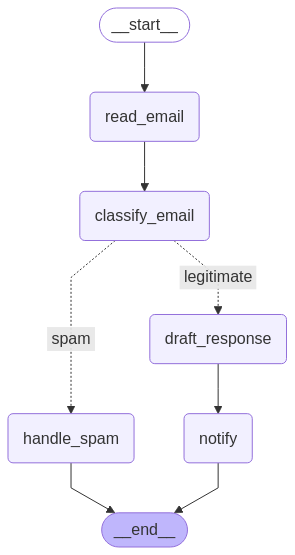

In [205]:
graph = StateGraph(EmailState)

graph.add_node("read_email", read_email)
graph.add_node("classify_email", classify_email)
graph.add_node("handle_spam", handle_spam)
graph.add_node("draft_response", draft_response)
graph.add_node("notify", notify)

graph.add_edge(START, "read_email")

graph.add_edge("read_email", "classify_email")

graph.add_conditional_edges(
    "classify_email",
    route_email,
    {
        "spam": "handle_spam",
        "legitimate": "draft_response"
    }
)
graph.add_edge("handle_spam", END)

graph.add_edge("draft_response", "notify")
graph.add_edge("notify", END)

graph = graph.compile()
graph

In [206]:
legitimate_email = {
    "sender": "john.smith@example.com",
    "subject": "Question about your services",
    "body": "Dear Mr. Hugg, I was referred to you by a colleague and I'm interested in learning more about your consulting services. Could we schedule a call next week? Best regards, John Smith"
}

# Example spam email
spam_email = {
    "sender": "winner@lottery-intl.com",
    "subject": "YOU HAVE WON $5,000,000!!!",
    "body": "CONGRATULATIONS! You have been selected as the winner of our international lottery! To claim your $5,000,000 prize, please send us your bank details and a processing fee of $100."
}

In [207]:
legitimate_email_content = EmailContent(**legitimate_email)
legitimate_email_state = EmailState(
    email=legitimate_email_content,
    email_category=None,
    spam_reason=None,
    is_spam=None,
    email_draft=None,
)


spam_email_content = EmailContent(**spam_email)
spam_email_state = EmailState(
    email=spam_email_content,
    email_category=None,
    spam_reason=None,
    
    is_spam=None,
    email_draft=None,
)

In [208]:
graph.invoke(spam_email_state)

Foodics' HR is processing an email from winner@lottery-intl.com with subject: YOU HAVE WON $5,000,000!!!
Email category: spam
email=EmailContent(subject='YOU HAVE WON $5,000,000!!!', sender='winner@lottery-intl.com', body='CONGRATULATIONS! You have been selected as the winner of our international lottery! To claim your $5,000,000 prize, please send us your bank details and a processing fee of $100.') email_category=None spam_reason=None is_spam=None email_draft=None messages=[]
email is not spam
IN notify

Sir, you've received an email from winner@lottery-intl.com.
Subject: YOU HAVE WON $5,000,000!!!
Category: None

I've prepared a draft response for your review:
--------------------------------------------------
None



{'email': EmailContent(subject='YOU HAVE WON $5,000,000!!!', sender='winner@lottery-intl.com', body='CONGRATULATIONS! You have been selected as the winner of our international lottery! To claim your $5,000,000 prize, please send us your bank details and a processing fee of $100.'),
 'email_category': None,
 'spam_reason': None,
 'is_spam': None,
 'email_draft': None,
 'messages': []}

In [172]:
from typing import Optional, List

class EmailContent(BaseModel):
    subject: str
    sender: str
    body: str

class MessageContent(BaseModel):
    role: str
    content: str


class EmailState(BaseModel):
    email: EmailContent
    email_category: Optional[str] = None
    spam_reason: Optional[str] = None

    is_spam: Optional[bool] = None
    email_draft: Optional[str] = None
    messages: List[MessageContent] = []

In [160]:
import pprint

sample_dict = {'name': 'Nik', 'age': 31, 'gender': 'male', 'books': ['Harry Potter', 'Lord of the Rings']}
print(sample_dict)

{'name': 'Nik', 'age': 31, 'gender': 'male', 'books': ['Harry Potter', 'Lord of the Rings']}
